# Data Retrieval

In [1]:
import pandas as pd
import csv
import re
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
plt.style.use('seaborn')

In [3]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}/calendar.csv'

sf_file = file_url.format('sf_airbnb')
ok_file = file_url.format('ok_airbnb')
sc_file = file_url.format('sc_airbnb')

In [4]:
# Loaded price by date information for each city

pricing_sf = pd.read_csv(sf_file, parse_dates=['date'])
pricing_ok = pd.read_csv(ok_file, parse_dates=['date'])
pricing_sc = pd.read_csv(sc_file, parse_dates=['date'])

print(pricing_sf.shape, pricing_ok.shape, pricing_sc.shape)

(2420680, 4) (1057770, 4) (2068820, 4)


In [5]:
# Concatenated all files into one
# Created keys for each file for future references

frames = [pricing_sf, pricing_ok, pricing_sc]
keys = ['pricing_sf', 'pricing_ok', 'pricing_sc']

df_pricing = pd.concat(frames, keys=keys)

df_pricing.head(10)

listing_id       date available price
pricing_sf 0         958 2019-08-05         f   NaN
           1         958 2019-08-04         f   NaN
           2         958 2019-08-03         f   NaN
           3         958 2019-08-02         f   NaN
           4         958 2019-08-01         f   NaN
           5         958 2019-07-31         f   NaN
           6         958 2019-07-30         f   NaN
           7         958 2019-07-29         f   NaN
           8         958 2019-07-28         f   NaN
           9         958 2019-07-27         f   NaN

# Data Exploration

## Smaller Set of Data

In [6]:
# Filter to houses that are available and have listing prices

df_pricing_smaller = df_pricing[df_pricing['available']=='t']
df_pricing_smaller = df_pricing_smaller.copy()

print('Dimension for df_pricing_smaller: ', df_pricing_smaller.shape)
print ('\nNumber of Unique ids: ', df_pricing_smaller.listing_id.nunique())

Dimension for df_pricing_smaller:  (2588352, 4)

Number of Unique ids:  13452


In [7]:
df_pricing_smaller.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

## Data Format

In [8]:
def apply2df(df, column_names, function):
    """
    This enables various functions to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to (list), function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

### Currency

In [9]:
# Noted currencies are formated as strings and need to be converted to float

def currency2float(string):
    """
    Convert currency to float
    """
    float_ = float(str(string).strip('$').replace(',',''))
    return float_

In [10]:
# Converted price to float format

curriencies = ['price']

df_pricing_smaller = apply2df(df_pricing_smaller, curriencies, currency2float)

## Outliers

In [11]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

df_pricing_smaller.price.describe(percentiles=percentiles)

count    2.588352e+06
mean     2.056189e+02
std      7.335415e+02
min      1.000000e+01
5%       4.000000e+01
10%      5.000000e+01
25%      7.800000e+01
50%      1.290000e+02
75%      2.090000e+02
90%      3.500000e+02
95%      5.000000e+02
max      1.024520e+05
Name: price, dtype: float64

In [12]:
# Removed outliers based on 'price'. Use 5% and 95% percentiles as cutoff

five_percentile = np.percentile(df_pricing_smaller.price, 5)
ninety_five_percentile = np.percentile(df_pricing_smaller.price, 95)

df_pricing_smaller = df_pricing_smaller[(
                     df_pricing_smaller.price>=five_percentile)
                     & (df_pricing_smaller.price<=ninety_five_percentile)]

In [13]:
print ('df_pricing_smaller dimensions: ', df_pricing_smaller.shape)

df_pricing_smaller dimensions:  (2346265, 4)


## Null Values

In [14]:
df_pricing_smaller.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [15]:
df_pricing_smaller.shape

(2346265, 4)

In [16]:
columns2display = ['date', 'price']

df_pricing_smaller[columns2display].describe(include = 'all')

,date,price
count,2346265,2.346265e+06
unique,375,NaN
top,2018-11-03 00:00:00,NaN
freq,8671,NaN
first,2018-08-06 00:00:00,NaN
last,2019-08-15 00:00:00,NaN
mean,NaN,1.537473e+02
std,NaN,9.694863e+01
min,NaN,4.000000e+01
25%,NaN,8.000000e+01


## Seasonality Data

### Month and DOW Features

In [17]:
# Added 'month' column to extract month of date
# Added 'day_of_week' column to extact day of week. 
# Default format: Monday=0, Sunday=6

df_pricing_smaller['month'] = df_pricing_smaller['date'].dt.month
df_pricing_smaller['day_of_week'] = df_pricing_smaller['date'].dt.weekday


print('df_pricing_smaller dimensions', df_pricing_smaller.shape)
display(df_pricing_smaller.head())

df_pricing_smaller dimensions (2346265, 6)


listing_id       date available  price  month  day_of_week
pricing_sf 63         958 2019-05-02         t  181.0      5            3
           64         958 2019-05-01         t  181.0      5            2
           65         958 2019-04-30         t  181.0      4            1
           66         958 2019-04-29         t  181.0      4            0
           67         958 2019-04-28         t  181.0      4            6

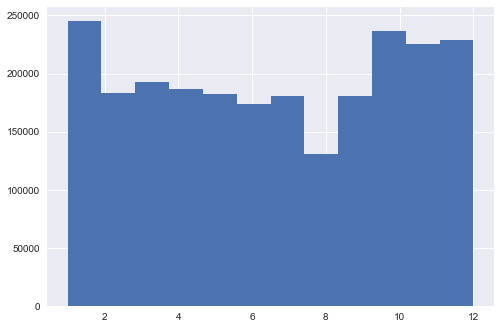

In [18]:
# Checked the price distribution by month

df_pricing_smaller.month.hist(bins=12)

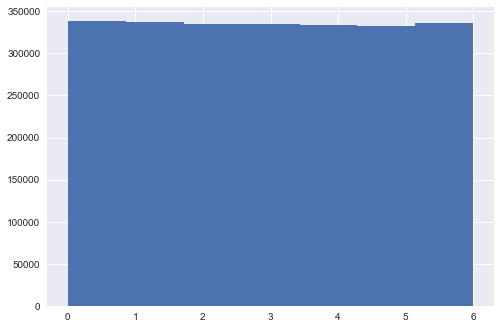

In [19]:
# Checked the price distribution by day of week

df_pricing_smaller.day_of_week.hist(bins=7)

### Pricing By Month by DOW

In [20]:
# Group by month by day of week, and calculate an average pricing

df_pricing_by_mon_dow = df_pricing_smaller  \
                            .groupby(['listing_id', 'month', 'day_of_week'])  \
                            .price.mean()  \
                            .reset_index()
df_pricing_by_mon_dow.head()

,listing_id,month,day_of_week,price
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0


In [21]:
# Check for null values if any

df_pricing_by_mon_dow.isnull().sum()

listing_id     0
month          0
day_of_week    0
price          0
dtype: int64

In [22]:
# Rename the average price column to avoid confusion

df_pricing_by_mon_dow.rename(columns={'price':'price_by_mon_dow'}, inplace=True)

In [23]:
df_pricing_by_mon_dow.shape

(625086, 4)

In [24]:
df_pricing_by_mon_dow.head()

,listing_id,month,day_of_week,price_by_mon_dow
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0


In [25]:
columns2display = ['price_by_mon_dow']

df_pricing_by_mon_dow[columns2display].describe()

,price_by_mon_dow
count,625086.000000
mean,154.025145
std,97.041053
min,40.000000
25%,80.000000
50%,128.000000
75%,199.000000
max,500.000000


### Month & DOW to Dummy Variables

In [26]:
def get_month(number):
    """
    Given a number, return the name of month.
    
    """
    month_lookup = {1:'Jan.', 2:'Feb.', 3:'Mar.', 4:'Apr.', 5:'May.', 6:'Jun.',
                    7:'Jul.', 8:'Aug.', 9:'Sep.', 10:'Oct.', 11:'Nov.', 12:'Dec.'}
    
    return month_lookup[number]

In [27]:
def get_dow(number):
    """
    Given a number, return the day of week (dow)
    
    """
    weekday_lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                      4:'Friday', 5:'Saturday', 6:'Sunday'}
    
    return weekday_lookup[number]

In [28]:
# Added names for month, and day of week(dow) informaiton

df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['month'], get_month )
df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['day_of_week'], get_dow )

In [29]:
# Converted month, and dow information to dummy variables

df_pricing_final = pd.get_dummies(df_pricing_by_mon_dow, 
                                  prefix='',
                                  prefix_sep='',
                                  columns=['month', 'day_of_week'])

print ('df_pricing_final dimensions: ', df_pricing_final.shape)
df_pricing_final.head()

df_pricing_final dimensions:  (625086, 21)


,listing_id,price_by_mon_dow,Apr.,Aug.,Dec.,Feb.,Jan.,Jul.,Jun.,Mar.,...,Nov.,Oct.,Sep.,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,958,180.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,958,179.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,958,183.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
df_pricing_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.', 'May.', 'Nov.', 'Oct.', 'Sep.',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

## Data Transformation

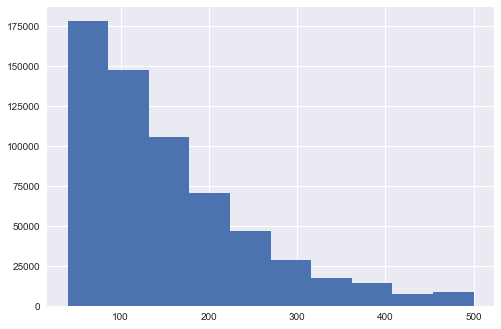

In [31]:
df_pricing_final.price_by_mon_dow.hist()

In [32]:
df_pricing_final['price_by_mon_dow_log'] = df_pricing_final['price_by_mon_dow']  \
                                           .apply(lambda x: np.log(x))

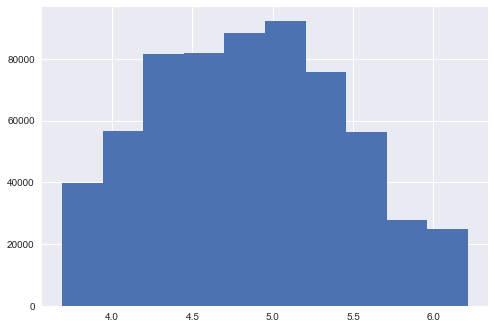

In [33]:
df_pricing_final.price_by_mon_dow_log.hist()

## Combined Seasonality Data with Previously Identified Features

In [34]:
# Loaded listings with identified important features

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings = pkl_file.format('df_listings_selected_features')

df_listings_features = pd.read_pickle(listings)

print ('df_listings_features dimensions: ', df_listings_features.shape)
df_listings_features.head()

df_listings_features dimensions:  (9062, 315)


,id,host_yrs,host_response_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Stepfree access,amenities_TV,amenities_Wifi,amenities_translation missing enhosting_amenity_49,amenities_translation missing enhosting_amenity_50,ref_district,ref_jurisdiction
0,958,12,0.92,1,3,1.0,1.0,2.0,170.0,1,...,1,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO
1,5858,11,1.00,2,5,1.0,2.0,3.0,235.0,1,...,1,0,1,0,0,1,0,0,San Francisco,SAN FRANCISCO
2,7918,11,1.00,10,2,4.0,1.0,1.0,65.0,1,...,0,0,1,0,1,1,1,1,San Francisco,SAN FRANCISCO
3,8142,11,1.00,10,2,4.0,1.0,1.0,65.0,1,...,0,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO
4,8567,11,0.80,1,6,1.0,2.0,3.0,255.0,0,...,1,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO


In [35]:
df_listings_features.columns

Index(['id', 'host_yrs', 'host_response_rate', 'host_listings_count',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit',
       ...
       'amenities_Shampoo', 'amenities_Single level home',
       'amenities_Smoke detector', 'amenities_Stepfree access', 'amenities_TV',
       'amenities_Wifi', 'amenities_translation missing enhosting_amenity_49',
       'amenities_translation missing enhosting_amenity_50', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=315)

In [36]:
# Combined listing data with seaonality information we just created

df_final = pd.merge(left=df_pricing_final, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [37]:
df_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Shampoo', 'amenities_Single level home',
       'amenities_Smoke detector', 'amenities_Stepfree access', 'amenities_TV',
       'amenities_Wifi', 'amenities_translation missing enhosting_amenity_49',
       'amenities_translation missing enhosting_amenity_50', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=337)

In [38]:
# Dropped duplicate columns

duplicate_columns = ['id']
df_final.drop(duplicate_columns, axis=1, inplace=True)

df_final.shape

(407498, 336)

## Features with High Correlation

In [39]:
# Create correlation matrix
# Select upper triangle of correlation matrix

corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [40]:
# Find index of feature columns with correlation greater than 0.90

thresold = 0.90
exclusion = ['price_by_mon_dow_log', 'price_by_mon_dow']

to_drop = [column for column in upper.columns if any(upper[column] >= thresold)
           and (column not in exclusion)]

to_drop

['price', 'price_log']

In [41]:
# Drop features that have high correlation

df_final.drop(to_drop, axis=1, inplace=True)

In [42]:
df_final.shape

(407498, 334)

In [43]:
# Store the data prior to modeling
# When there're changes, mark file_updated as true. Changes'll be written to local files
# Otherwise, mark file_updated as false. Data will be loaded from existing files

file_updated = True
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings_seasonality = pkl_file.format('listings_seasonality')


if file_updated:
    with open(listings_seasonality, 'wb') as file:
        pd.to_pickle(df_final, file)
else:
    try: 
        with open(listings_seasonality, 'rb') as file:
            df_final = pd.read_pickle(file)
    except:
        with open(listings_seasonality, 'wb') as file:
            pd.to_pickle(df_final, file)

# Modeling

In [44]:
df_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Shampoo', 'amenities_Single level home',
       'amenities_Smoke detector', 'amenities_Stepfree access', 'amenities_TV',
       'amenities_Wifi', 'amenities_translation missing enhosting_amenity_49',
       'amenities_translation missing enhosting_amenity_50', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=334)

In [45]:
df_final.select_dtypes(include =['object']).columns

Index(['ref_district', 'ref_jurisdiction'], dtype='object')

In [46]:
# Multiple modelings will be performed for price prediction
# Data include 'listing_id', which will be used for stratified sampling

X = df_final.drop(['price_by_mon_dow_log', 'price_by_mon_dow', 
                   'ref_district', 'ref_jurisdiction'], axis=1)
y = df_final.loc[:, ['listing_id', 'price_by_mon_dow_log']]

## Model Preprocessing

### Train and Test Sets Splits

In [47]:
# Stratified sampling to prevent information leakage
# Identified all available listing_ids and split by listing_ids

grp_by_listing_ids = df_final.groupby('listing_id').first().reset_index().listing_id
listing_ids = list(grp_by_listing_ids)

In [48]:
num_of_grps = len(grp_by_listing_ids)
training_ids = np.random.choice(listing_ids, int(num_of_grps*0.7),
                                replace=False)

print(len(training_ids))
training_ids

5814


array([25809348,    62214,  6810714, ..., 12025202, 20311264, 22108513])

In [49]:
testing_ids = set(grp_by_listing_ids) - set (training_ids)

len(testing_ids)

2493

In [50]:
# Stratified sampling: splited train and test sets. 
# Dropped 'listing_id' column

X_train = X[X['listing_id'].isin(training_ids)].drop('listing_id', axis=1)
X_test = X[X['listing_id'].isin(testing_ids)].drop('listing_id', axis=1)

y_train = y[y['listing_id'].isin(training_ids)].drop('listing_id', axis=1).values.ravel()
y_test = y[y['listing_id'].isin(testing_ids)].drop('listing_id', axis=1).values.ravel()

print(len(X_train), len(X_test), len(y_train), len(y_test))

284420 123078 284420 123078


### Feature Normalization

In [51]:
ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Linear Regression

### Simple Linear Regression

In [52]:
# Model-LR

model=sm.OLS(y_train, sm.add_constant(X_train_trans))
fit=model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2652.
Date:                Sun, 24 Feb 2019   Prob (F-statistic):               0.00
Time:                        02:15:40   Log-Likelihood:                -58087.
No. Observations:              284420   AIC:                         1.168e+05
Df Residuals:                  284116   BIC:                         1.200e+05
Df Model:                         303                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8287      0.001   8669.368      0.000       4.828       4.830
x1         -1.676e+08   1.23e+09     -0.136      0.892   -2.58e+09    2.24e+09
x2         -1.924e+08   1.41e+09     -0.136      0.892   -2.96e+09    2.57e+09
x3         -1.896e+08   1.39e+09     -0.136      0.892   -2.91e+09    2.54e+09
x4          -1.82e+08   1.34e+09     -0.136      0.892    -2.8e+09    2.43e+09
x5         -1.905e+08    1.4e+09     -0.136      0.892   -2.93e+09    2.55e+09
x6         -1.616e+08   1.19e+09     -0.136      0.892   -2.48e+09    2.16e+09
x7         -1.613e+08   1.18e+09     -0.136      0.892   -2.48e+09    2.16e+09
x8         -1.675e+08   1.23e+09     -0.136      0.892   -2.58e+09    2.24e+09
x9         -1.657e+08   1.22e+09     -0.136      0.892   -2.55e+09    2.22e+09
x10        -1.995e+08   1.46e+09     -0.136      0.892   -3.07e+09    2.67e+09
x11        -1.989e+08   1.46e+09     -0.136      0.892   -3.06e+09    2.66e+09
x12        -1.894e+08   1.39e+09     -0.136      0.892   -2.91e+09    2.53e+09
x13         5.505e+08   9.22e+09      0.060      0.952   -1.75e+10    1.86e+10
x14         5.482e+08   9.18e+09      0.060      0.952   -1.75e+10    1.85e+10
x15         5.467e+08   9.16e+09      0.060      0.952   -1.74e+10    1.85e+10
x16         5.487e+08   9.19e+09      0.060      0.952   -1.75e+10    1.86e+10
x17         5.496e+08   9.21e+09      0.060      0.952   -1.75e+10    1.86e+10
x18         5.444e+08   9.12e+09      0.060      0.952   -1.73e+10    1.84e+10
x19          5.45e+08   9.13e+09      0.060      0.952   -1.73e+10    1.84e+10
x20            0.0043      0.001      5.469      0.000       0.003       0.006
x21            0.0044      0.001      4.190      0.000       0.002       0.007
x22            0.0273      0.001     30.756      0.000       0.026       0.029
x23            0.1327      0.001    104.272      0.000       0.130       0.135
x24           -0.0111      0.001    -15.690      0.000      -0.012      -0.010
x25            0.1122      0.001    111.113      0.000       0.110       0.114
x26           -0.0111      0.001    -10.158      0.000      -0.013      -0.009
x27            0.0027      0.001      4.372      0.000       0.001       0.004
x28            0.0384      0.001     47.136      0.000       0.037       0.040
x29            0.0307      0.001     39.601      0.000       0.029       0.032
x30           -0.0262      0.001    -38.364      0.000      -0.028      -0.025
x31           -0.0016      0.001     -1.505      0.132      -0.004       0.000
x32           -0.0192      0.001    -18.695      0.000      -0.021      -0.017
x33            0.0253      0.001     20.236      0.000       0.023       0.028
x34            0.0050      0.001      5.034      0.000       0.003       0.007
x35            0.0535      0.001     58.761      0.000       0.052       0.055
x3

### Lasso

In [53]:
est = make_pipeline(PolynomialFeatures(), Lasso())

In [54]:
est.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'lasso', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [55]:
params ={'polynomialfeatures__degree':[1], 
         'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
        }

In [56]:
grid = GridSearchCV(est, param_grid=params, cv=3, 
                    return_train_score=True,  n_jobs =-1)
grid.fit(X_train_trans, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1], 'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [57]:
grid.best_params_

{'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1}

In [58]:
grid.cv_results_['params']

[{'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 1, 'polynomialfeatures__degree': 1}]

In [59]:
grid.best_score_

0.6702445004315492

## Tree Based Regression

### Boosting Tree

In [60]:
estimators = [100, 200]
depth = [3, 5, 8, 10]

r2_scores_gbr = []
MSEs_gbr = []
gbrs = []


for e in estimators:
    for d in depth:

        gbr = GradientBoostingRegressor(random_state=42, n_estimators=e, max_depth=d)
        gbr.fit(X_train_trans, y_train.ravel())

        preds = gbr.predict(X_test_trans)
        score = r2_score(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        
        gbrs.append([e, d, gbr]) 
        r2_scores_gbr.append([e, d, score])
        MSEs_gbr.append([e, d, mse])

In [61]:
for index, value in enumerate(r2_scores_gbr):
    print ('Estimator:', value[0], ', max_depth:', value[1], 
           ', R2 score:', '%.3f'%(value[2]),
           'MSE:', '%.3f'%(MSEs_gbr[index][2]) )

Estimator: 100 , max_depth: 3 , R2 score: 0.754 MSE: 0.081
Estimator: 100 , max_depth: 5 , R2 score: 0.768 MSE: 0.076
Estimator: 100 , max_depth: 8 , R2 score: 0.776 MSE: 0.074
Estimator: 100 , max_depth: 10 , R2 score: 0.776 MSE: 0.074
Estimator: 200 , max_depth: 3 , R2 score: 0.767 MSE: 0.077
Estimator: 200 , max_depth: 5 , R2 score: 0.777 MSE: 0.073
Estimator: 200 , max_depth: 8 , R2 score: 0.779 MSE: 0.073
Estimator: 200 , max_depth: 10 , R2 score: 0.778 MSE: 0.073


### Random Forest

In [62]:
estimators = [100, 200, 300]
depth = [3, 5, 10]
rfs = []
r2_scores_rf = []
MSEs_rf = []


# Model-Random Forest

for e in estimators:
    for d in depth:
        rf = RandomForestRegressor(n_estimators=e, 
                                   max_depth=d,
                                   criterion='mse', 
                                   random_state=42, 
                                   n_jobs=-1)
        rf.fit(X_train_trans, y_train.ravel())

        preds = rf.predict(X_test_trans)
        score = r2_score(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        
        rfs.append([e, d, rf])
        r2_scores_rf.append([e, d, score])
        MSEs_rf.append([e, d, mse])

In [63]:
for index, value in enumerate(r2_scores_rf):
    print ('Estimator:', value[0], ', max_depth:', value[1], 
           ', R2 score:', '%.3f'%(value[2]),
           'MSE:', '%.3f'%(MSEs_rf[index][2]) )

Estimator: 100 , max_depth: 3 , R2 score: 0.579 MSE: 0.139
Estimator: 100 , max_depth: 5 , R2 score: 0.649 MSE: 0.115
Estimator: 100 , max_depth: 10 , R2 score: 0.707 MSE: 0.097
Estimator: 200 , max_depth: 3 , R2 score: 0.579 MSE: 0.139
Estimator: 200 , max_depth: 5 , R2 score: 0.650 MSE: 0.115
Estimator: 200 , max_depth: 10 , R2 score: 0.707 MSE: 0.097
Estimator: 300 , max_depth: 3 , R2 score: 0.580 MSE: 0.138
Estimator: 300 , max_depth: 5 , R2 score: 0.650 MSE: 0.115
Estimator: 300 , max_depth: 10 , R2 score: 0.707 MSE: 0.096


## Feature Selection

In [79]:
# Noted boosting tree with 200 estimators and 8 max_depth produces best result

gbr_e200_d8 = gbrs[6][2]

In [80]:
# Sorted feature by importance

feature_labels = X_train.columns
feature_tuples = zip (feature_labels, gbr_e200_d8.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]
feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)

display (feature_lists[0:5])

[['reviews_per_month', 0.06004200141891048],
 ['number_of_reviews', 0.045429855172575945],
 ['cleaning_fee', 0.04501802378948796],
 ['room_type_Entire home/apt', 0.034049276429660595],
 ['accommodates', 0.030531050598067055]]

In [67]:
# Kept features that are above 0.001 thresold

thres = 0.001

features_selected = [feature for feature, importance in feature_lists
                    if importance >= thres]
nums_features_selected = len(features_selected)

print ('Number of features kept: ', nums_features_selected)

Number of features kept:  196


## Updated Model with Selected Features

In [68]:
# Performed another model(Random Forest) based on selected features

X_train_updated = X_train[features_selected]
X_test_updated = X_test[features_selected]

In [69]:
ss2 = StandardScaler()
X_train_trans_updated = ss.fit_transform(X_train_updated)
X_test_trans_updated = ss.transform(X_test_updated)

In [70]:
# Updated boosting tree model with selected features

gbr_updated = GradientBoostingRegressor(
              random_state=42, n_estimators=200, max_depth=8)
gbr_updated.fit(X_train_trans_updated, y_train.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [81]:
preds_updated = gbr_updated.predict(X_test_trans_updated)
score_updated = r2_score(y_test, preds_updated)
mse_updated = mean_squared_error(y_test, preds_updated)

print ('R2s score: %.3f'%(score_updated), ', MSE: %.3f'%(mse_updated))

R2s score: 0.779 , MSE: 0.073


# Data Storage

In [83]:
# 'ref_dist', 'ref_juri', 'ref_jurisdiction', 'price_by_month_week'


columns =['listing_id', 'ref_district', 'ref_jurisdiction', 'price_by_mon_dow']
columns.extend(features_selected)

In [84]:
df_data = df_final[columns]
df_data.head()

,listing_id,ref_district,ref_jurisdiction,price_by_mon_dow,reviews_per_month,number_of_reviews,cleaning_fee,room_type_Entire home/apt,accommodates,host_listings_count,...,neighbourhood_cleansed_Highland Terrace,neighbourhood_cleansed_Shafter,neighbourhood_cleansed_Fremont,neighbourhood_cleansed_Webster,neighbourhood_cleansed_Caballo Hills,neighbourhood_cleansed_Durant Manor,neighbourhood_cleansed_Golf Links,neighbourhood_cleansed_San Pablo Gateway,neighbourhood_cleansed_Lynn-Highland Park,neighbourhood_cleansed_Fitchburg
0,958,San Francisco,SAN FRANCISCO,180.0,1.38,152,100.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
1,958,San Francisco,SAN FRANCISCO,179.5,1.38,152,100.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2,958,San Francisco,SAN FRANCISCO,179.5,1.38,152,100.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
3,958,San Francisco,SAN FRANCISCO,179.0,1.38,152,100.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
4,958,San Francisco,SAN FRANCISCO,183.0,1.38,152,100.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0


In [85]:
df_data.shape

(407498, 200)

In [87]:
csv_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

csv_path = csv_file.format('airbnb_data')

df_data.to_csv(csv_path)

In [89]:
# temp_df = df_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].copy()

# days = temp_df.apply(lambda x: x.idxmax(), axis=1)
# days

# P.S. Pricie Seasonality

In [90]:
# This is to identify seasonality pattern

df_visual = pd.merge(left=df_pricing_by_mon_dow, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [92]:
df_visual.shape

(407498, 319)

In [95]:
# Price by dow for all apartment types

df_by_dow = df_visual.groupby(['ref_district', 'day_of_week'])  \
                     .price_by_mon_dow.mean()
df_by_dow

ref_district   day_of_week
Oakland        Friday         120.767372
               Monday         117.471899
               Saturday       121.058804
               Sunday         118.008274
               Thursday       117.556023
               Tuesday        117.142522
               Wednesday      117.344513
San Francisco  Friday         173.806462
               Monday         167.981110
               Saturday       173.784742
               Sunday         169.095354
               Thursday       168.670277
               Tuesday        168.104305
               Wednesday      168.052583
Santa Clara    Friday         136.325082
               Monday         134.858146
               Saturday       136.225450
               Sunday         134.766806
               Thursday       135.357829
               Tuesday        135.305526
               Wednesday      135.605740
Name: price_by_mon_dow, dtype: float64

In [96]:
df_by_mon = df_visual.groupby(['ref_district', 'month'])  \
                     .price_by_mon_dow.mean()
df_by_mon

ref_district   month
Oakland        Apr.     123.011585
               Aug.     118.333182
               Dec.     119.472456
               Feb.     118.060416
               Jan.     118.714664
               Jul.     123.801546
               Jun.     124.109276
               Mar.     122.657703
               May.     123.081401
               Nov.     111.351815
               Oct.     113.503525
               Sep.     115.025610
San Francisco  Apr.     168.868004
               Aug.     175.033169
               Dec.     167.503836
               Feb.     167.903980
               Jan.     169.889133
               Jul.     170.565861
               Jun.     169.988888
               Mar.     168.965796
               May.     167.865573
               Nov.     164.750004
               Oct.     170.017649
               Sep.     177.789215
Santa Clara    Apr.     140.837415
               Aug.     134.163078
               Dec.     134.828051
               Feb.     136.617036

In [97]:
df_visual_ent_apart = df_visual[df_visual['room_type_Entire home/apt']==1 ]
df_visual_sing_room = df_visual[df_visual['room_type_Entire home/apt']!=1 ]

print(df_visual_ent_apart.shape, df_visual_sing_room.shape )

(216975, 319) (190523, 319)


In [100]:
# Weekly pattern for entire apartment

df_ent_apart_by_dow = df_visual_ent_apart.groupby(['ref_district', 'day_of_week'])  \
                                         .price_by_mon_dow.mean()
df_ent_apart_by_dow

ref_district   day_of_week
Oakland        Friday         151.028933
               Monday         146.200905
               Saturday       151.393272
               Sunday         147.249513
               Thursday       146.529586
               Tuesday        145.668259
               Wednesday      146.044186
San Francisco  Friday         211.177964
               Monday         204.813449
               Saturday       211.109980
               Sunday         205.917327
               Thursday       205.669198
               Tuesday        205.042800
               Wednesday      204.863768
Santa Clara    Friday         204.755467
               Monday         203.117403
               Saturday       204.360394
               Sunday         202.663630
               Thursday       203.922394
               Tuesday        203.767863
               Wednesday      204.424058
Name: price_by_mon_dow, dtype: float64

In [101]:
# Weekly pattern for single room

df_sing_room_by_dow = df_visual_sing_room.groupby(['ref_district', 'day_of_week'])  \
                                         .price_by_mon_dow.mean()
df_sing_room_by_dow

ref_district   day_of_week
Oakland        Friday          75.503706
               Monday          73.765381
               Saturday        75.507196
               Sunday          73.547569
               Thursday        73.802102
               Tuesday         73.691687
               Wednesday       73.764326
San Francisco  Friday         124.724201
               Monday         119.657800
               Saturday       124.368007
               Sunday         120.494809
               Thursday       120.571680
               Tuesday        119.798881
               Wednesday      120.029255
Santa Clara    Friday          79.822268
               Monday          78.567982
               Saturday        79.825026
               Sunday          78.528311
               Thursday        78.618272
               Tuesday         78.595941
               Wednesday       78.560329
Name: price_by_mon_dow, dtype: float64

In [103]:
# Monthly Pattern for entire apartment

df_ent_apart_by_mon = df_visual_ent_apart.groupby(['ref_district', 'month'])  \
                                         .price_by_mon_dow.mean()
df_ent_apart_by_mon

ref_district   month
Oakland        Apr.     152.970769
               Aug.     148.046702
               Dec.     147.074091
               Feb.     144.675173
               Jan.     145.036679
               Jul.     153.580032
               Jun.     154.348160
               Mar.     152.671308
               May.     153.089479
               Nov.     140.798115
               Oct.     144.104286
               Sep.     145.338658
San Francisco  Apr.     204.427314
               Aug.     214.192272
               Dec.     203.903778
               Feb.     203.842070
               Jan.     206.127438
               Jul.     206.556149
               Jun.     206.050272
               Mar.     205.269812
               May.     203.235148
               Nov.     201.374033
               Oct.     210.140963
               Sep.     218.031384
Santa Clara    Apr.     211.881164
               Aug.     204.718970
               Dec.     198.585578
               Feb.     202.676910

In [105]:
# Monthly Pattern for single room

df_sing_room_by_mon = df_visual_sing_room.groupby(['ref_district', 'month'])  \
                                         .price_by_mon_dow.mean()

df_sing_room_by_mon

ref_district   month
Oakland        Apr.      74.916126
               Aug.      75.835302
               Dec.      73.145327
               Feb.      74.318976
               Jan.      73.073431
               Jul.      74.663438
               Jun.      74.567812
               Mar.      75.157040
               May.      74.674819
               Nov.      72.251279
               Oct.      73.197049
               Sep.      76.137786
San Francisco  Apr.     118.745724
               Aug.     127.420532
               Dec.     118.117639
               Feb.     117.829924
               Jan.     119.175408
               Jul.     118.703700
               Jun.     118.634880
               Mar.     118.176623
               May.     118.150702
               Nov.     118.061622
               Oct.     124.222997
               Sep.     133.589617
Santa Clara    Apr.      80.019167
               Aug.      78.932060
               Dec.      76.965656
               Feb.      79.407598